In [1]:
import pandas as pd
import fpsnippets as fp
import numpy as np
import geopandas as gp
%matplotlib inline
import matplotlib.pyplot as plt

#Create the data fram from the .csv
asb = pd.read_csv("asbestos.csv", sep=",", low_memory=False)
nbhInfo = pd.read_csv("neighborhoods.csv", sep=",", low_memory=False)

#Add a column for the neighborhoods to be placed
asb['neighborhood'] = ''

#Setting up the dictionaries for the amount of occurances in the asbestos.csv and the square milage of each neighborhood
nbhNums = dict()
nbhSqMiles = dict()


#Iterate through the dataframe and add the neighborhood based on coors, then zip if no coors
for index, row in asb.iterrows():    
    outGeo = fp.geo_to_neighborhood(row['latitude'], row['longitude'])
    outZip = fp.zip_to_neighborhoods(row['z_code'])
    final = ""
    if outGeo != "None":
        final = outGeo
    elif outZip!= "None":
        final = outZip
    else:
        final = "None"
    
    asb.at[index, "neighborhood"] = final
    
    #Manages a dictionary that I use later for my data frame
    if not(final in nbhNums):
        nbhNums[final] = int(1)
    else:
        nbhNums[final] += int(1)

#Removes data points with no location data
del nbhNums[None]

#Manually added cities from other datasets that were not in Asbestos
nbhNums["Chartiers City"] = 0
nbhNums["Arlington Heights"] = 0
nbhNums["Glen Hazel"] = 0

#This pulls the square mile information for the various neighborhoods and puts them in a dictionary
for index, row in nbhInfo.iterrows():
        nbhSqMiles[row['hood']] = row['sqmiles']

#This takes a while to compile, so I have this message for the sake of my sanity
print("Data imported!")

Data imported!


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e4fdd7160>,
      dtype=object)

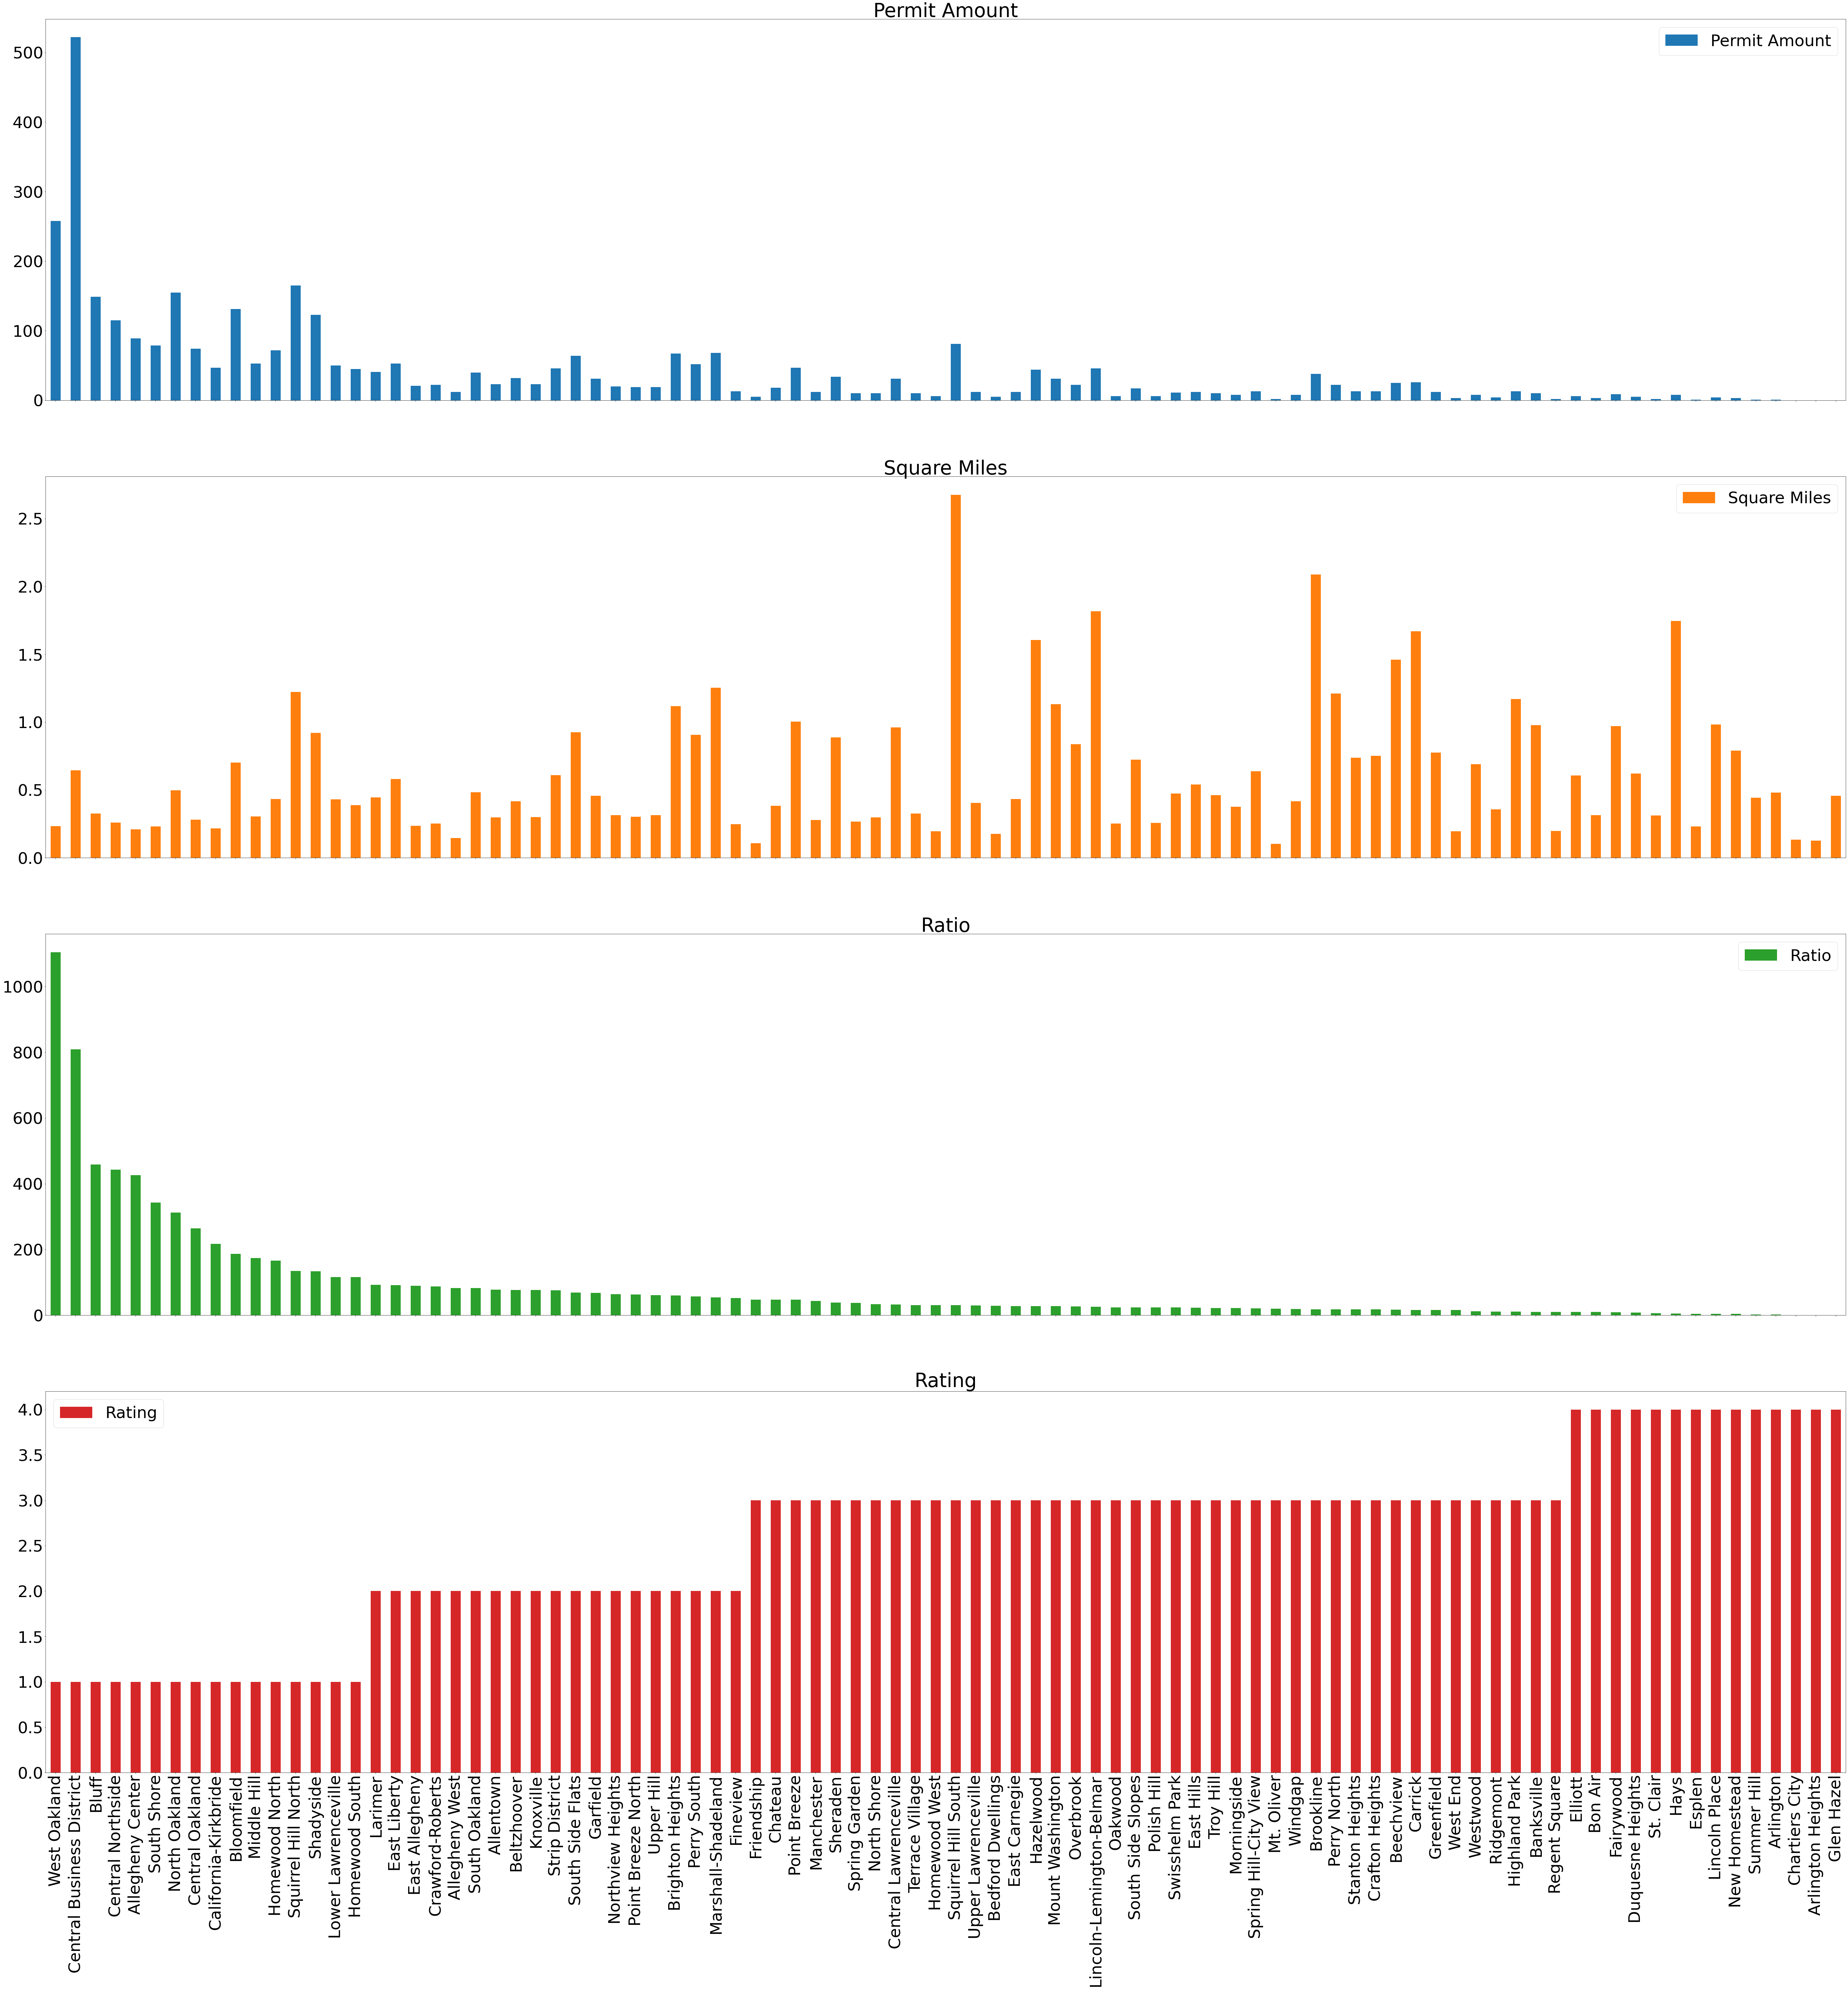

In [15]:
#This is for adjusting font size. Before I found this, the neighborhoods were unreadable
plt.rcParams.update({'font.size': 50})

#The final dataframe that I create from all the other previous dataframe and dictionaries
occur = pd.Series(nbhNums).sort_values(ascending=False).to_frame()

#Assigns the column name for the 1st set of data, then adds columns for the other data that will be added.
occur.columns =['Permit Amount']
occur['Square Miles'] = ''
occur['Ratio'] = ''
occur['Rating'] = ''
occur['hood'] = ''

for index, row in occur.iterrows():
    #I determine the ratio by (amount of permits / square miles)
    ratio = row['Permit Amount']/float(nbhSqMiles[index])
    
    #I made a general tier system for the neighborhoods based off the calculated ratio
    if ratio>100:
        rate = 1
    elif (ratio>50):
        rate = 2
    elif (ratio>10):
        rate = 3
    else:
        rate = 4
    
    #This just fills in the rest of the data set as it iterates
    occur.at[index,'Rating'] = rate
    occur.at[index,'Square Miles'] = nbhSqMiles[index]
    occur.at[index,'Ratio'] = ratio
    occur.at[index,'hood'] = index

#I decided to use bar graphs for the time being, I may look into other types later. Figsize determines the dimensions, subplots makes a unique graph for each set of values in the frame.
occur.sort_values(by=['Ratio'], ascending=False).plot.bar(figsize=(100,100), subplots=True)

/opt/tljh/user/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/opt/tljh/user/lib/python3.8/site-packages/mapclassify/classifiers.py:1718: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(ms, UserWarning)
/opt/tljh/user/lib/python3.8/site-packages/mapclassify/classifiers.py:1719: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % uvk, UserWarning)


Text(0.5, 1.0, 'Asbestos Density')

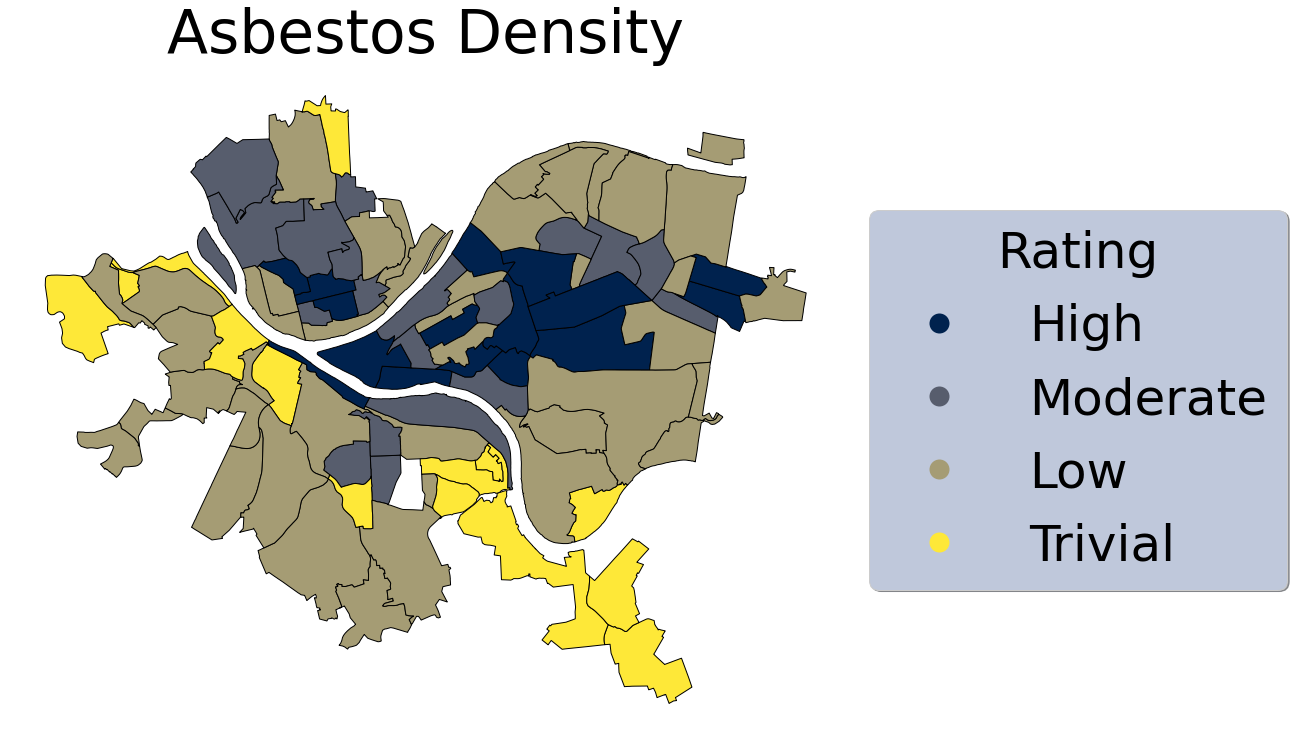

In [80]:
shapeMap = gp.read_file("neighborhoodShapes/Neighborhoods_.dbf")

finalMap = shapeMap.merge(occur, on='hood')

fig,ax = plt.subplots(figsize=(15,15))
finalMap.plot(ax=ax, column='Rating', cmap = 'cividis', edgecolor='black', legend=True, scheme='natural_breaks', legend_kwds={"labels": ["High", "Moderate", "Low", "Trivial"], "title": "Rating", "loc": "center left", "bbox_to_anchor": (1, 0.5), "shadow": "True", "facecolor": "#bfc8db", "markerscale": 2.0})
#finalMap.plot(ax=ax, color='white', edgecolor='black')
#occur.plot(ax=ax, cmap = 'OrRd')
ax.axis("off")
ax.set_title("Asbestos Density", fontdict={})